In [66]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

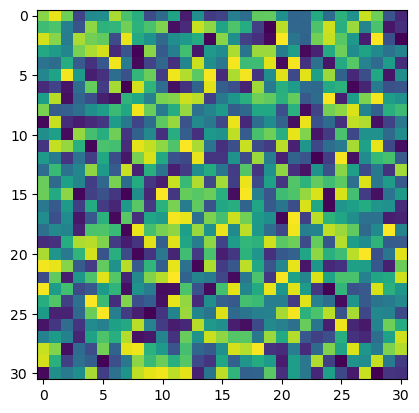

In [67]:
im = torch.rand((500, 4, 31, 31))
plt.imshow(im[0, 0])

In [68]:
def interp(x) : return F.interpolate(x, (63, 63), mode="bilinear", align_corners=False)

def my_interp(x):
    channels = x.shape[1]
    n, m = x.shape[-2:]
    kernel = torch.tensor([
        [1/4, 1/2, 1/4],
        [1/2, 1. , 1/2],
        [1/4, 1/2, 1/4]
    ])
    filter = torch.zeros((channels, channels, 3, 3))
    for k in range(channels):
        filter[k, k] = kernel

    new_shape = list(x.shape)
    new_shape[-2:] = [2*(n+1) - 1, 2*(m+1) - 1]
    x_new = torch.zeros(new_shape) 
    x_new[..., 1::2, 1::2] = x
    return F.conv2d(x_new, filter, None, padding=1)

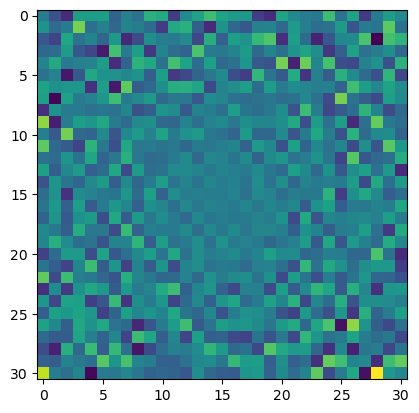

In [69]:
plt.imshow((interp(im)[..., 1::2, 1::2]-im)[0,0])

In [70]:
%timeit interp(im)

5.35 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [71]:
%timeit my_interp(im)

46.7 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
def interp_mat(n):
    out = 2*n - 1
    mat = torch.zeros((n-1, out))

    stencil = 1/2 * torch.tensor([1., 2., 1.])

    for i in range(n-1):
        mat[i, 2*i: 2*i + 3] = stencil

    # correct for edges
    # mat[0, :2] = torch.tensor([1., 0.5])
    # mat[-1, -2:] = torch.tensor([0.5, 1.])

    return mat.T


def slow_interp(im):
    x = torch.clone(im)

    n, m = x.shape[-2:]
    left = interp_mat(n + 1)
    right = interp_mat(m + 1).T
    return torch.matmul(left, torch.matmul(x, right))

In [73]:
%timeit slow_interp(im)

33.9 ms ± 998 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
def restrict(im):
    return im[..., 1::2, 1::2]

def res_clone(im):
    x = torch.clone(im)
    return x[..., 1::2, 1::2]

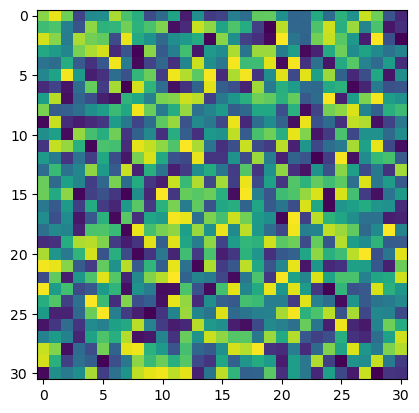

In [75]:
plt.imshow(im[0,0])

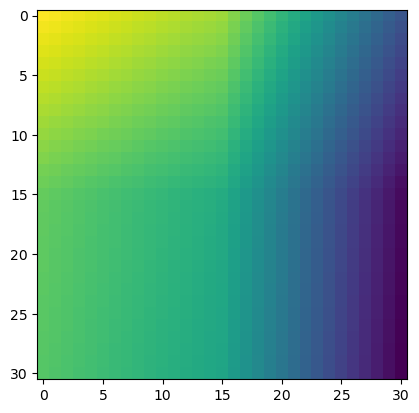

In [85]:
for i in range(100):
    im = restrict(interp(im))
    
plt.imshow(im[0,0])